# 量子启发式算法GPU后端使用教程

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_qaia_gpu_tutorial.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_qaia_gpu_tutorial.py)&emsp;
[![在Gitee上查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/case_library/qaia_gpu_tutorial.ipynb)

本篇教程将从下面五点进行说明：

- 检查系统环境，保证GPU显卡可用。
- 介绍MindQuantum和量子启发式算法。
- 介绍量子启发式算法GPU后端支持的精度类型，提供样例代码。
- 使用量子启发式算法GPU后端求解最大割问题。
- 对比量子启发式算法在CPU和GPU后端上的性能差异

## 检查系统环境

在使用量子启发式算法GPU后端来求解问题前，需要确保系统环境已经安装GPU显卡和CUDA环境，并且显卡可用：

- GPU显卡：推荐系统安装NVIDIA英伟达显卡
- CUDA环境：建议安装CUDA 11及以上版本

In [1]:
# 输出系统显卡型号、数量、驱动版本和CUDA版本
!nvidia-smi

Tue Jun 10 14:49:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100S-PCIE-32GB          On  | 00000000:92:00.0 Off |                    0 |
| N/A   43C    P0              39W / 250W |    410MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# 检查GPU显卡是否可用
import torch

torch.cuda.is_available()

True

## MindQuantum

量子启发式算法是一类基于**量子力学原理**的计算方法衍生或启发的经典力学方法，旨在利用量子力学的独特性质（叠加态、量子纠缠和量子并行性）来改进传统算法的性能。

常见的**量子启发式算法**包括：

- ASB（Adiabatic Simulated bifurcation/绝热模拟分叉算法）
- BSB（Ballistic Simulated bifurcation/弹道模拟分叉算法）
- DSB（Discrete Simulated bifurcation/离散模拟分叉算法）
- SimCIM（Simulated Coherent Ising Machine/模拟相干伊辛机算法）
- LQA（Local Quantum Annealing/局部量子退火算法）

**MindQuantum**是基于昇思MindSpore开源深度学习平台开发的新一代通用量子计算框架，聚焦于NISQ阶段的算法实现与落地。结合HiQ高性能量子计算模拟器和昇思MindSpore并行自动微分能力，提供极简的开发模式和极致的性能体验。

MindQuantum已经[集成量子启发式算法模块](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/algorithm/mindquantum.algorithm.qaia.html)，并提供**CPU、GPU、NUP/昇腾**版本，适配多种硬件设备，并提供极致性能。

## 量子启发式算法GPU后端

量子启发式算法[支持后端](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/algorithm/qaia/mindquantum.algorithm.qaia.QAIA.html#mindquantum.algorithm.qaia.QAIA)：

- backend (str) - 计算后端和精度：'cpu-float32'、'gpu-float32'、'gpu-float16'、'gpu-int8' 或 'npu-float32'，默认值： 'cpu-float32'。
- GPU后端提供3种数据精度：float32、float16和int8，低精度int8可以大幅提升计算速度，但是会小概率导致准确度丢失。

In [4]:
# 样例代码
from scipy.sparse import coo_matrix
from mindquantum.algorithm.qaia import BSB

# 矩阵[[0,-1],[-1,0]]
J = coo_matrix(([-1, -1], ([0, 1], [1, 0])), shape=(2, 2))
solver = BSB(J, batch_size=10, backend="gpu-float32")
solver.update()
cut = solver.calc_cut()
energy = solver.calc_energy()

print(f"Cut: {cut}\nEnergy: {energy}")

Cut: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Energy: tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], device='cuda:0')


## 使用量子启发式算法求解最大割问题

In [5]:
# 导入需要的Python模块
from mindquantum.algorithm.qaia import BSB
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix

In [ ]:
# 数据准备
# 下载数据，无向图数据集来源于GSet
import requests

graph_file = "https://web.stanford.edu/~yyye/yyye/Gset/G22"

# 使用requests库中的get方法发送HTTP请求，将url的响应结果存入变量，再以二进制写入模式打开文件写入本地
response = requests.get(graph_file)
open("G22", "wb").write(response.content)


# 如果上述-下载图集的代码执行，报错TimeoutError，说明是网络问题
# 可以手动点击网址 https://web.stanford.edu/~yyye/yyye/Gset/G22，下载数据，保存在本地，与该教程同级目录

In [6]:
# 数据处理
def read_gset(filename, negate=True):
    # 读取图表
    graph = pd.read_csv(filename, sep=" ")
    # 节点的数量
    n_v = int(graph.columns[0])
    # 边的数量
    n_e = int(graph.columns[1])

    # 如果节点和边不匹配，会抛出错误
    assert n_e == graph.shape[0], "The number of edges is not matched"

    # 将读取的数据转换为一个COO矩阵（Coordinate List Format），并返回一个稀疏矩阵
    G = coo_matrix(
        (
            np.concatenate([graph.iloc[:, -1], graph.iloc[:, -1]]),
            (
                np.concatenate([graph.iloc[:, 0] - 1, graph.iloc[:, 1] - 1]),
                np.concatenate([graph.iloc[:, 1] - 1, graph.iloc[:, 0] - 1]),
            ),
        ),
        shape=(n_v, n_v),
    )
    if negate:
        G = -G

    return G


G = read_gset("./G22")

In [8]:
solver = BSB(G, batch_size=100, n_iter=1000, backend="gpu-float32")
solver.update()
cut = solver.calc_cut()

print(f"MAXCut is : {max(cut)}")

MAXCut is : 13333.0


## 性能对比

对比BSB算法在CPU和GPU后端上求解最大割问题的性能差异

In [9]:
import time

start_time = time.time()
solver = BSB(G, batch_size=100, n_iter=1000, backend="cpu-float32")
solver.update()
cut = solver.calc_cut()
cpu_time = time.time() - start_time

start_time = time.time()
solver = BSB(G, batch_size=100, n_iter=1000, backend="gpu-float32")
solver.update()
cut = solver.calc_cut()
gpu_fp32_time = time.time() - start_time

start_time = time.time()
solver = BSB(G, batch_size=100, n_iter=1000, backend="gpu-float16")
solver.update()
cut = solver.calc_cut()
gpu_fp16_time = time.time() - start_time

start_time = time.time()
solver = BSB(G, batch_size=100, n_iter=1000, backend="gpu-int8")
solver.update()
cut = solver.calc_cut()
gpu_fp8_time = time.time() - start_time

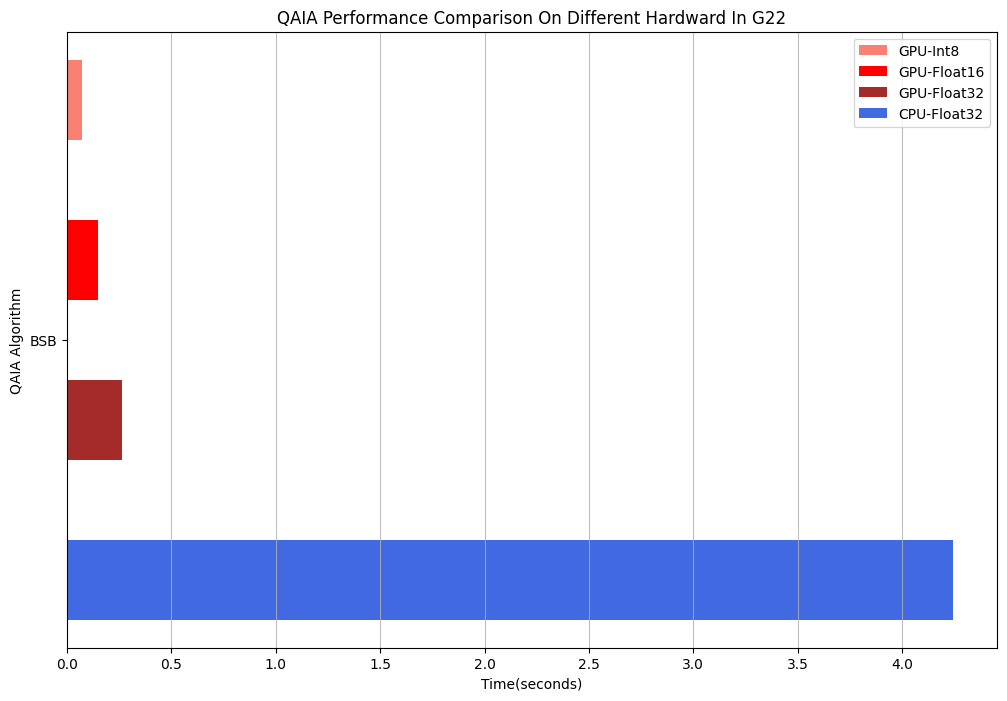

In [10]:
import matplotlib.pyplot as plt

# 绘制水平条形图，表示不同后端的计算时间
plt.figure(figsize=(12, 8))
plt.barh(0.6, gpu_fp8_time, height=0.1, label="GPU-Int8", color="salmon")
plt.barh(0.4, gpu_fp16_time, height=0.1, label="GPU-Float16", color="red")
plt.barh(0.2, gpu_fp32_time, height=0.1, label="GPU-Float32", color="brown")
plt.barh(0, cpu_time, height=0.1, label="CPU-Float32", color="royalblue")

plt.title("QAIA Performance Comparison On Different Hardware In G22")
plt.xlabel("Time(seconds)")
plt.ylabel("QAIA Algorithm")
plt.yticks((0.3,), ("BSB",))

plt.grid(True, axis="x", linestyle="-", alpha=0.8)
plt.legend()
plt.show()

In [11]:
from mindquantum.utils.show_info import InfoTable

InfoTable("mindquantum", "scipy", "numpy")

Software,Version
mindquantum,0.10.1
scipy,1.11.3
numpy,1.26.1
System,Info
Python,3.10.13
OS,Linux x86_64
Memory,810.22 GB
CPU Max Thread,96
Date,Tue Jun 10 14:55:10 2025
